In [1]:
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.io
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import matplotlib.pyplot as plt
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary
import time
from livelossplot import PlotLosses

In [38]:
train_transform = Compose(
    [ToTensor(),
    Normalize(mean=(0.1307,), std=(0.3081,))
    ])
test_transform = Compose(
    [ToTensor(),
    Normalize(mean=(0.1307,), std=(0.3081,))
    ])

In [39]:
BATCH_SIZE = 4

# 1. Recolher dados

In [40]:
def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    print(train_mat.keys())
    print(test_mat.keys())
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    print('Train shape: ',train_np.shape)
    print('Test shape: ',test_np.shape)
    return  train_np, test_np


train_data, test_data = get_data_from_mat('train_data.mat','test_data.mat')

dict_keys(['__header__', '__version__', '__globals__', 'train_data'])
dict_keys(['__header__', '__version__', '__globals__', 'test_data'])
Train shape:  (112, 90, 90)
Test shape:  (28, 90, 90)


## 2. Preparar os datasets de treino e de teste

In [41]:
#Tornar cada matriz num vetor de uma dimensão (passar de 90x90 para 8100) e armazenar todos os valores de cada matriz
#O dicionário utilizado armazena, todos os valores com indíce X, pertencentes às diferentes 112 matrizes, sendo esse índice
#a chave do dic.
#Por exemplo: dictAttributes[0] contém o primeiro elemento de cada vetor anteriormente criado
dictAttributes = dict()
for i in range(len(train_data)):# len(train_data) - 112
    flatten_data = train_data[i].flatten()
    for j in range(len(flatten_data)):
        dictAttributes.setdefault(j,list())
        dictAttributes[j].append(flatten_data[j])
len(dictAttributes)

8100

In [42]:
#Tornar cada matriz num vetor de uma dimensão (passar de 90x90 para 8100) e armazenar todos os valores de cada matriz
#O dicionário utilizado armazena, todos os valores com indíce X, pertencentes às diferentes 112 matrizes, sendo esse índice
#a chave do dic.
#Por exemplo: dictAttributes[0] contém o primeiro elemento de cada vetor anteriormente criado
dictAttributesTest = dict()
for i in range(len(test_data)):# len(test_data) - 28
    flatten_data = test_data[i].flatten()
    for j in range(len(flatten_data)):
        dictAttributesTest.setdefault(j,list())
        dictAttributesTest[j].append(flatten_data[j])
len(dictAttributesTest)

8100

In [43]:
#Nesta fase criam-se colunas com todos os elementos que estão numa dada posição do vetor, a label da coluna é essa posição
scans_series = []
for k in dictAttributes.keys():
    scans_series.append(pd.Series(dictAttributes.get(k)))

In [44]:
#Nesta fase criam-se colunas com todos os elementos que estão numa dada posição do vetor, a label da coluna é essa posição
scans_series_test = []
for k in dictAttributesTest.keys():
    scans_series_test.append(pd.Series(dictAttributesTest.get(k)))

In [45]:
train_data_series = pd.concat(scans_series,axis=1)
train_data_series

,0,1,2,3,4,5,6,7,8,9,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,0.0,0.0,0.131525,0.0,0.0,0.0,0.271538,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.585006,0.0,0.280606,0.0,0.0
1,0.0,0.0,0.117704,0.0,0.0,0.0,0.316890,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.599437,0.0,0.207478,0.0,0.0
2,0.0,0.0,0.155806,0.0,0.0,0.0,0.348072,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.630374,0.0,0.246472,0.0,0.0
3,0.0,0.0,0.145214,0.0,0.0,0.0,0.310270,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.562505,0.0,0.287888,0.0,0.0
4,0.0,0.0,0.161360,0.0,0.0,0.0,0.385560,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.564043,0.0,0.234284,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.0,0.0,0.215767,0.0,0.0,0.0,0.390332,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.011150,0.0,0.660292,0.0,0.302675,0.0,0.0
108,0.0,0.0,0.143005,0.0,0.0,0.0,0.306380,0.0,0.0,0.0,...,0.0,0.011171,0.0,0.019141,0.0,0.630415,0.0,0.204125,0.0,0.0
109,0.0,0.0,0.116085,0.0,0.0,0.0,0.290941,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.574355,0.0,0.246784,0.0,0.0
110,0.0,0.0,0.156654,0.0,0.0,0.0,0.357540,0.0,0.0,0.0,...,0.0,0.010225,0.0,0.000000,0.0,0.631057,0.0,0.216259,0.0,0.0


In [46]:
test_data_series = pd.concat(scans_series_test,axis=1).sample(frac=1.0, random_state=2022).reset_index(drop=True)
test_data_series

,0,1,2,3,4,5,6,7,8,9,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,0.0,0.0,0.101044,0.000000,0.0,0.0,0.337020,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.014537,0.0,0.611550,0.0,0.291660,0.0,0.0
1,0.0,0.0,0.134865,0.000000,0.0,0.0,0.422271,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.583719,0.0,0.292009,0.0,0.0
2,0.0,0.0,0.129573,0.000000,0.0,0.0,0.337631,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.590000,0.0,0.266638,0.0,0.0
3,0.0,0.0,0.159263,0.000000,0.0,0.0,0.341810,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.555549,0.0,0.204871,0.0,0.0
4,0.0,0.0,0.203059,0.018586,0.0,0.0,0.420286,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.010584,0.0,0.684640,0.0,0.240465,0.0,0.0
5,0.0,0.0,0.122592,0.000000,0.0,0.0,0.328413,0.0,0.0,0.0,...,0.0,0.014708,0.0,0.000000,0.0,0.596880,0.0,0.259705,0.0,0.0
6,0.0,0.0,0.142985,0.000000,0.0,0.0,0.350861,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.702736,0.0,0.267522,0.0,0.0
7,0.0,0.0,0.084421,0.000000,0.0,0.0,0.363210,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.016944,0.0,0.640797,0.0,0.249482,0.0,0.0
8,0.0,0.0,0.091724,0.000000,0.0,0.0,0.338758,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.577096,0.0,0.260915,0.0,0.0
9,0.0,0.0,0.117093,0.000000,0.0,0.0,0.370942,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.640091,0.0,0.320452,0.0,0.0


In [47]:
test_df_all = pd.DataFrame(test_data_series)
test_df_all

,0,1,2,3,4,5,6,7,8,9,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,0.0,0.0,0.101044,0.000000,0.0,0.0,0.337020,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.014537,0.0,0.611550,0.0,0.291660,0.0,0.0
1,0.0,0.0,0.134865,0.000000,0.0,0.0,0.422271,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.583719,0.0,0.292009,0.0,0.0
2,0.0,0.0,0.129573,0.000000,0.0,0.0,0.337631,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.590000,0.0,0.266638,0.0,0.0
3,0.0,0.0,0.159263,0.000000,0.0,0.0,0.341810,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.555549,0.0,0.204871,0.0,0.0
4,0.0,0.0,0.203059,0.018586,0.0,0.0,0.420286,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.010584,0.0,0.684640,0.0,0.240465,0.0,0.0
5,0.0,0.0,0.122592,0.000000,0.0,0.0,0.328413,0.0,0.0,0.0,...,0.0,0.014708,0.0,0.000000,0.0,0.596880,0.0,0.259705,0.0,0.0
6,0.0,0.0,0.142985,0.000000,0.0,0.0,0.350861,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.702736,0.0,0.267522,0.0,0.0
7,0.0,0.0,0.084421,0.000000,0.0,0.0,0.363210,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.016944,0.0,0.640797,0.0,0.249482,0.0,0.0
8,0.0,0.0,0.091724,0.000000,0.0,0.0,0.338758,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.577096,0.0,0.260915,0.0,0.0
9,0.0,0.0,0.117093,0.000000,0.0,0.0,0.370942,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.640091,0.0,0.320452,0.0,0.0


## 2.1. Adicionar mais informação para treino

In [48]:
TRAIN_CSV_PATH = 'train.csv'

In [49]:
rest_train_df = pd.read_csv(TRAIN_CSV_PATH)
rest_train_df.head(10) #Tem 112 linhas

,id,age,sex,education
0,1,13,1,7
1,2,14,0,8
2,3,15,1,9
3,4,15,1,9
4,5,15,1,9
5,6,15,1,9
6,7,16,0,10
7,8,16,1,10
8,9,16,0,10
9,10,17,0,11


In [50]:
targets_train = rest_train_df['age']
targets_train

0      13
1      14
2      15
3      15
4      15
       ..
107    77
108    67
109    55
110    76
111    69
Name: age, Length: 112, dtype: int64

In [51]:
train_data_series = pd.concat([targets_train] + scans_series,axis=1).sample(frac=1.0, random_state=2022).reset_index(drop=True)
train_data_series

,age,0,1,2,3,4,5,6,7,8,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,53,0.0,0.0,0.173673,0.019753,0.0,0.0,0.399909,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.615459,0.0,0.113210,0.0,0.0
1,40,0.0,0.0,0.122071,0.000000,0.0,0.0,0.295469,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.596293,0.0,0.256004,0.0,0.0
2,69,0.0,0.0,0.330159,0.000000,0.0,0.0,0.389147,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.676865,0.0,0.197393,0.0,0.0
3,24,0.0,0.0,0.144803,0.000000,0.0,0.0,0.352847,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.653635,0.0,0.227650,0.0,0.0
4,55,0.0,0.0,0.116085,0.000000,0.0,0.0,0.290941,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.574355,0.0,0.246784,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,63,0.0,0.0,0.153905,0.000000,0.0,0.0,0.272740,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.577098,0.0,0.194381,0.0,0.0
108,61,0.0,0.0,0.178360,0.000000,0.0,0.0,0.306510,0.0,0.0,...,0.0,0.011916,0.0,0.0,0.0,0.723154,0.0,0.200323,0.0,0.0
109,22,0.0,0.0,0.134661,0.000000,0.0,0.0,0.361852,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.532999,0.0,0.238360,0.0,0.0
110,27,0.0,0.0,0.116392,0.000000,0.0,0.0,0.303962,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.570106,0.0,0.231983,0.0,0.0


In [52]:
train_df_all = pd.DataFrame(train_data_series)
train_df_all

,age,0,1,2,3,4,5,6,7,8,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,53,0.0,0.0,0.173673,0.019753,0.0,0.0,0.399909,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.615459,0.0,0.113210,0.0,0.0
1,40,0.0,0.0,0.122071,0.000000,0.0,0.0,0.295469,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.596293,0.0,0.256004,0.0,0.0
2,69,0.0,0.0,0.330159,0.000000,0.0,0.0,0.389147,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.676865,0.0,0.197393,0.0,0.0
3,24,0.0,0.0,0.144803,0.000000,0.0,0.0,0.352847,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.653635,0.0,0.227650,0.0,0.0
4,55,0.0,0.0,0.116085,0.000000,0.0,0.0,0.290941,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.574355,0.0,0.246784,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,63,0.0,0.0,0.153905,0.000000,0.0,0.0,0.272740,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.577098,0.0,0.194381,0.0,0.0
108,61,0.0,0.0,0.178360,0.000000,0.0,0.0,0.306510,0.0,0.0,...,0.0,0.011916,0.0,0.0,0.0,0.723154,0.0,0.200323,0.0,0.0
109,22,0.0,0.0,0.134661,0.000000,0.0,0.0,0.361852,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.532999,0.0,0.238360,0.0,0.0
110,27,0.0,0.0,0.116392,0.000000,0.0,0.0,0.303962,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.570106,0.0,0.231983,0.0,0.0


In [53]:
class MyDataset(Dataset):

    def __init__(self, df, transform=None):
        self.transform = transform

        df_set = df

        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]

        self.x = self.x.astype('float32')
        self.le = LabelEncoder()
        self.y = self.le.fit_transform(self.y)
        self.y = self.y.astype('long')
        
    def get_le(self):
        return self.le
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 90, 90)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 
    
class MyDatasetTest(Dataset):

    def __init__(self, df, transform=None):
        self.transform = transform

        df_set = df

        self.x = df_set.values[:, :]

        self.x = self.x.astype('float32')
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 90, 90)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        cases = torch.utils.data.TensorDataset(x)
        return cases 

def prepare_data_loaders(df_train, df_test):
    dataset_train = MyDataset(df_train,transform=train_transform)
    le = dataset_train.get_le()
    dataset_test = MyDatasetTest(df_test,transform=test_transform)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.75 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(2022))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all, le

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all, le = prepare_data_loaders(train_df_all, test_df_all)

In [54]:
from IPython.display import display

def visualize_data(df):
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    #print(f"Shape tensor batch casos test, input: {x.shape}, output: {y.shape}")
    print(f'Valor máximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    x=x.detach().numpy()
    print(f'Valor máximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)
    
visualize_data(train_df_all)
visualize_dataset(train_dl, val_dl)

,age,0,1,2,3,4,5,6,7,8,...,8090,8091,8092,8093,8094,8095,8096,8097,8098,8099
0,53,0.0,0.0,0.173673,0.019753,0.0,0.0,0.399909,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.615459,0.0,0.113210,0.0,0.0
1,40,0.0,0.0,0.122071,0.000000,0.0,0.0,0.295469,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.596293,0.0,0.256004,0.0,0.0
2,69,0.0,0.0,0.330159,0.000000,0.0,0.0,0.389147,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.676865,0.0,0.197393,0.0,0.0
3,24,0.0,0.0,0.144803,0.000000,0.0,0.0,0.352847,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.653635,0.0,0.227650,0.0,0.0
4,55,0.0,0.0,0.116085,0.000000,0.0,0.0,0.290941,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.574355,0.0,0.246784,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,63,0.0,0.0,0.153905,0.000000,0.0,0.0,0.272740,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.577098,0.0,0.194381,0.0,0.0
108,61,0.0,0.0,0.178360,0.000000,0.0,0.0,0.306510,0.0,0.0,...,0.0,0.011916,0.0,0.0,0.0,0.723154,0.0,0.200323,0.0,0.0
109,22,0.0,0.0,0.134661,0.000000,0.0,0.0,0.361852,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.532999,0.0,0.238360,0.0,0.0
110,27,0.0,0.0,0.116392,0.000000,0.0,0.0,0.303962,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.570106,0.0,0.231983,0.0,0.0


Quantidade de casos de Treino:84
Quantidade de casos de Validação:28
Quantidade de casos de Teste:28
Shape tensor batch casos treino, input: torch.Size([4, 1, 90, 90]), output: torch.Size([4])
Shape tensor batch casos validação, input: torch.Size([4, 1, 90, 90]), output: torch.Size([4])
Valor máximo:1.0 Valor mínimo:0.0
Valor máximo:1.0 Valor mínimo:0.0
tensor([ 2, 46, 32, 22])


In [55]:
device = torch.device("cpu")

class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.fc1 = Linear(in_features=21*21*32, out_features=100)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=48)
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 21*21*32)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out) 
        out = self.act2(out)
        return out

model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,90,90), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               --                        --
├─Sequential: 1-1                        [4, 32, 44, 44]           --
│    └─Conv2d: 2-1                       [4, 32, 88, 88]           320
│    └─ReLU: 2-2                         [4, 32, 88, 88]           --
│    └─MaxPool2d: 2-3                    [4, 32, 44, 44]           --
├─Sequential: 1-2                        [4, 32, 21, 21]           --
│    └─Conv2d: 2-4                       [4, 32, 42, 42]           9,248
│    └─ReLU: 2-5                         [4, 32, 42, 42]           --
│    └─MaxPool2d: 2-6                    [4, 32, 21, 21]           --
├─Linear: 1-3                            [4, 100]                  1,411,300
├─ReLU: 1-4                              [4, 100]                  --
├─Linear: 1-5                            [4, 48]                   4,848
├─Softmax: 1-6                           [4, 48]                   --
T

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=14112, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=48, bias=True)
  (act2): Softmax(dim=1)
)

In [56]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #print('outputs: ', outputs)
            #print('labels: ', labels)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
            
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            print('Preds: ', preds)
            print('Labels: ', labels)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()
        
    torch.save(model,h5_file)

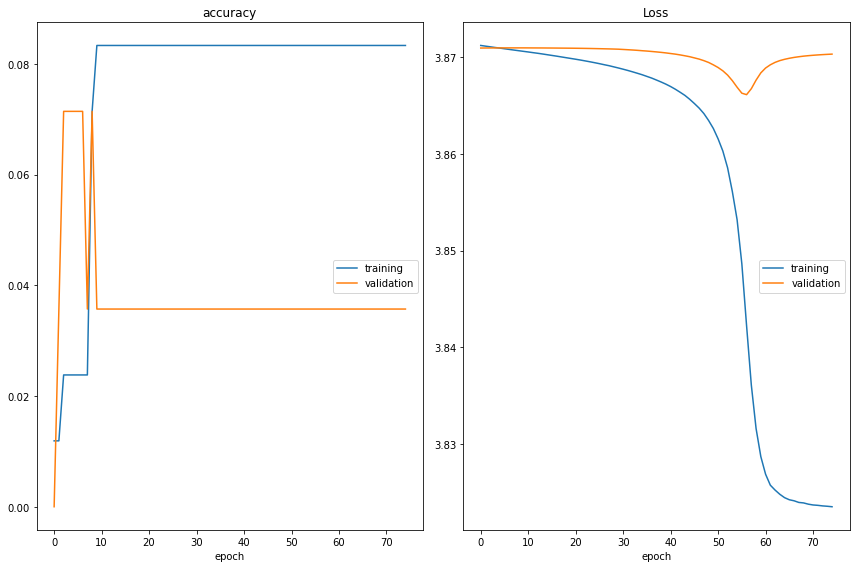

accuracy
	training         	 (min:    0.012, max:    0.083, cur:    0.083)
	validation       	 (min:    0.000, max:    0.071, cur:    0.036)
Loss
	training         	 (min:    3.824, max:    3.871, cur:    3.824)
	validation       	 (min:    3.866, max:    3.871, cur:    3.870)
Tempo gasto: 82.39075170000001 segundos


In [57]:
model = CNNModel_1()

print(summary(model, input_size=(BATCH_SIZE, 1,90,90), verbose=0))
model.to(device)
EPOCHS = 75
LEARNING_RATE = 0.01
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE)
starttime = time.perf_counter()
train_model('CNNModel_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [58]:
import csv

def predict(test_dl, model):
    predictions = list()
    #actual_values = list()
    for inputs in test_dl:
        inputs = inputs[0]
        inputs = inputs.to(device)
        #labels = labels.to(device)
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        #actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        #actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        #actual_values.append(actual)
        break
    predictions = np.vstack(predictions)
    return predictions

predictions = predict(test_dl_all, model).flatten()
predictions_ages = [int(i) for i in le.inverse_transform(predictions)]
predictions_ages


with open('test_submission.csv', 'w', encoding='UTF8', newline='') as f:
    count_id = 1
    writer = csv.writer(f)
    writer.writerow(['id','age'])
    for age in predictions_ages:
        line = [count_id, age]
        writer.writerow(line)
        count_id += 1